# Consolidation Breakup Strategy Backtest

## Import necessary modules

In [1]:
import os
import sys
from loguru import logger

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sixty_million.config import DATA_URL
from sixty_million.config import BASE_URL
from sixty_million.config import API_KEY_ID
from sixty_million.config import API_KEY_SECRET
from sixty_million.backtest.backtest import Backtest
from sixty_million.backtest.strategy.consolidation_breakup_stg import BConsolidationBreakupStg

import pandas as pd
import requests, json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Initializing some utilities
logger.remove()
logger.add(sys.stdout, format="[{level}] {message}", filter=lambda record: record["level"].name in ["INFO", "DEBUG"])
logger.add(sys.stderr, format="[{level}] {message}", filter=lambda record: record["level"].name not in ["INFO", "DEBUG"])

2

## Load data
We use Alpaca API to load history data. Data reading module is written in sixty-million/market directory. We need bar and trade data.

We need to configure some query parameters:

* symbol - stock symbol we want to query for
* start_time - starting time in RFC-3339 format. Fractions of a second are not accepted.
* end_time - starting time in RFC-3339 format. Fractions of a second are not accepted.
* limit - batch size. 1 - 10000
* processor - the function that handles the trade data

### Load trade data

In [3]:
def load_trade_data(symbol, start, end):
    trade_data_url = '{base}/v2/stocks/{symbol}/trades'.format(base=DATA_URL, symbol=symbol)
    next_token = None
    limit = 10000
    
    trade_data = []

    params = {
        'start': start,
        'end': end,
        'limit': limit,
        'page_token': next_token
    }

    headers = {
        'APCA-API-KEY-ID': API_KEY_ID,
        'APCA-API-SECRET-KEY': API_KEY_SECRET
    }

    logger.info("Start to fetch trade data for {symbol} from {start} to {end}"
                .format(symbol=symbol, start=start, end=end))

    response = requests.get(url=trade_data_url, params=params, headers=headers)
    print(response.reason)
    content = json.loads(response.content)
    trade_data.extend(content['trades'])
    next_token = content['next_page_token']
    while next_token:
        params['page_token'] = next_token
        response = requests.get(url=trade_data_url, params=params, headers=headers)
        content = json.loads(response.content)
        trade_data.extend(content['trades'])
        next_token = content['next_page_token']

    trade_df = pd.DataFrame(trade_data)
    logger.info("Retrieved {} trade data".format(trade_df.shape[0]))
    return trade_df

In [5]:
def load_bar_data(symbol, start, end):
    bar_data_url = '{base}/v2/stocks/{symbol}/bars'.format(base=DATA_URL, symbol=symbol)
    next_token = None
    timeframe = '1Min'
    limit = 10000
    
    bar_data = []

    params = {
        'start': start,
        'end': end,
        'limit': limit,
        'timeframe': timeframe,
        'page_token': next_token
    }

    headers = {
        'APCA-API-KEY-ID': API_KEY_ID,
        'APCA-API-SECRET-KEY': API_KEY_SECRET
    }

    logger.info("Start to fetch bar data for {symbol} from {start} to {end}"
                .format(symbol=symbol, start=start, end=end))

    response = requests.get(url=bar_data_url, params=params, headers=headers)
    content = json.loads(response.content)
    bar_data.extend(content['bars'])
    next_token = content['next_page_token']
    while next_token:
        params['page_token'] = next_token
        response = requests.get(url=bar_data_url, params=params, headers=headers)
        content = json.loads(response.content)
        bar_data.extend(content['bars'])
        next_token = content['next_page_token']

    bar_df = pd.DataFrame(bar_data)
    logger.info("Retrieved {} bar data".format(bar_df.shape[0]))
    return bar_df

In [6]:
symbol = 'AMD'
start = '2023-03-23T09:30:00-04:00'
end = '2023-03-23T16:00:00-04:00'
trades = load_trade_data(symbol, start, end)
bars = load_bar_data(symbol, start, end)

[INFO] Start to fetch trade data for AMD from 2023-03-23T09:30:00-04:00 to 2023-03-23T16:00:00-04:00
OK
[INFO] Retrieved 492245 trade data
[INFO] Start to fetch bar data for AMD from 2023-03-23T09:30:00-04:00 to 2023-03-23T16:00:00-04:00
[INFO] Retrieved 391 bar data


## Initialize and setup Backtrader
We use Backtest module for backtesting. Firstly we need to configure backtest parameters

In [7]:
BACKTEST_START = '2023-03-23T09:30:03-04:00' # Set the start time to 2 seconds later to avoid a bug
BACKTEST_END = '2023-03-23T16:00:00-04:00'
CONSOLIDATION_PERIOD = 3
CONSOLIDATION_RELATIVE_STD_THRESHOLD = 0.009
CONSOLIDATION_VOLUME_BREAKUP_RATIO = 1.3
CONSOLIDATION_BUY_SIGNAL_COMPARING_PRICE = 'highest' # possible values are highest, high_avg
CONSOLIDATION_PRICE_BREAKUP_RATIO = 1.00
CONSOLIDATION_SELL_MINUTES = 2
CONSOLIDATION_GAP_MINUTES = 2
RISK_REWARD_RATIO = 1.3

In [8]:
bt = Backtest()

bt.set_time_range(BACKTEST_START, BACKTEST_END)
bt.set_data(bars, trades)

stg = BConsolidationBreakupStg(symbol,
                               bt.broker,
                               consolidation_period=CONSOLIDATION_PERIOD,
                               consolidation_relative_std_threshold=CONSOLIDATION_RELATIVE_STD_THRESHOLD, 
                               consolidation_volume_breakup_ratio=CONSOLIDATION_VOLUME_BREAKUP_RATIO,
                               consolidation_buy_signal_comparing_price=CONSOLIDATION_BUY_SIGNAL_COMPARING_PRICE,
                               consolidation_price_breakup_ratio=CONSOLIDATION_PRICE_BREAKUP_RATIO,
                               consolidation_sell_minutes=CONSOLIDATION_SELL_MINUTES,
                               consolidation_gap_minutes=CONSOLIDATION_GAP_MINUTES,
                               risk_reward_ratio=RISK_REWARD_RATIO)

bt.set_strategy(stg)
bt.run(consolidation_period = CONSOLIDATION_PERIOD)

[INFO] Loaded <bound method BDataFeed.get_bar_data_dimension of <sixty_million.backtest.data.data_feed.BDataFeed object at 0x115201940>> bars and <bound method BDataFeed.get_trade_data_dimension of <sixty_million.backtest.data.data_feed.BDataFeed object at 0x115201940>> trades
[INFO] Fetching previous bars before current start time: 2023-03-23 09:30:03-04:00
[INFO] Fetching trades between minute start and start time
[INFO] We are buying the stock at 2023-03-23 09:38:57.722223556-04:00 with price 100.37. Profit taking is 101.38400000000003 and stop loss is 99.58999999999999
[INFO] We are selling stock at 2023-03-23 09:40:57.741258027-04:00 with price 99.8343 because stock is in consolidation again
[INFO] We are buying the stock at 2023-03-23 09:43:29.055489260-04:00 with price 100.5701. Profit taking is 101.66656333333331 and stop loss is 99.72666666666667
[INFO] We are selling stock at 2023-03-23 09:45:29.096870040-04:00 with price 100.465 because stock is in consolidation again
[INFO]

[INFO] We are buying the stock at 2023-03-23 15:50:32.145597207-04:00 with price 100.88. Profit taking is 101.82003 and stop loss is 100.1569
[INFO] We are selling stock at 2023-03-23 15:52:32.161458512-04:00 with price 100.44 because stock is in consolidation again
[INFO] We are at the end of iteration for trades
[INFO] We started the simulation with $100000
[INFO] We executed 60 trades
[INFO] Our trade accuracy (profitable trade) is 60.0%
[INFO] We ended the simulation with $101775.31390000004
[INFO] Change percentage is 1.7753139000000373%


## Plotting result

### Plot backtest result

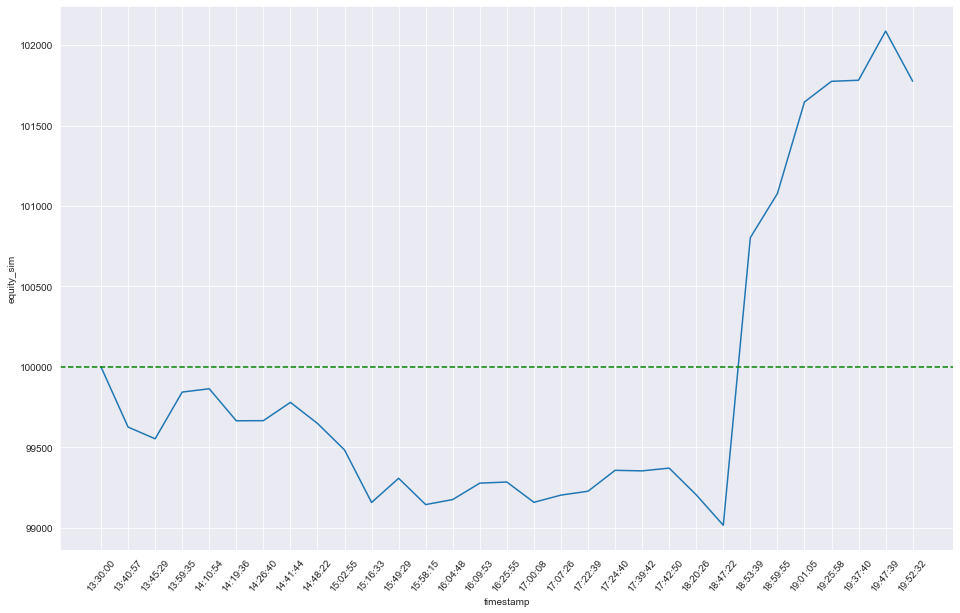

In [9]:
sns.set_style('darkgrid')
plt.subplots(figsize=(16,10))
graph = sns.lineplot(data=bt.result_dp, x='timestamp', y='equity_sim')
graph.axhline(100000, ls='--', c='green')
plt.xticks(rotation=50)
plt.show()

**Run the following section only if you want to compare paper trading result vs backtest result for same stock. Currently it only support the use case that you only trade 1 stock in paper trading account for the entire day. Otherwise the data will not be accurate.**

### Plotting backtest and paper trading result comparison

In [23]:
def get_portfolio_history():
    bar_data_url = '{base}/v2/account/portfolio/history'.format(base=BASE_URL)
    timeframe = '1Min'
    period = '1D'
    
    params = {
        'period': period,
        'timeframe': timeframe,
        'extended_hours': False
    }

    headers = {
        'APCA-API-KEY-ID': API_KEY_ID,
        'APCA-API-SECRET-KEY': API_KEY_SECRET
    }
    
    response = requests.get(url=bar_data_url, params=params, headers=headers)
    content = json.loads(response.content)
    return content

In [35]:
# Prepare simulator result to conform with structure of backtest
backtest_result = bt.result_dp.copy()
backtest_result['timestamp'] = pd.to_datetime(backtest_result['timestamp'])
backtest_result['timestamp'] = backtest_result['timestamp'].round('min')
backtest_result['timestamp'] = backtest_result['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Eastern')
backtest_result = backtest_result.set_index('timestamp')
grouped = backtest_result.groupby(level=0)
backtest_result = grouped.last()

In [43]:
portfolio_response = get_portfolio_history()
portfolio_df = pd.DataFrame(portfolio_response)[:-1]
portfolio_df.drop(['profit_loss', 'profit_loss_pct', 'base_value', 'timeframe'], axis=1, inplace=True)
portfolio_df['equity'] += 75000
portfolio_df['timestamp'] = pd.to_datetime(portfolio_df['timestamp'], unit='s')
portfolio_df['timestamp'] = portfolio_df['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Eastern')
paper_trading_result = portfolio_df
paper_trading_result = paper_trading_result.set_index('timestamp')

In [44]:
integrated_result = paper_trading_result.copy()
integrated_result['equity_sim'] = 0
prev_equity = 100000
for index in integrated_result.index:
    if index in backtest_result.index:
        es = backtest_result.loc[index].equity_sim
        integrated_result.at[index, 'equity_sim'] = es
        prev_equity = es
    else:
        integrated_result.at[index, 'equity_sim'] = prev_equity


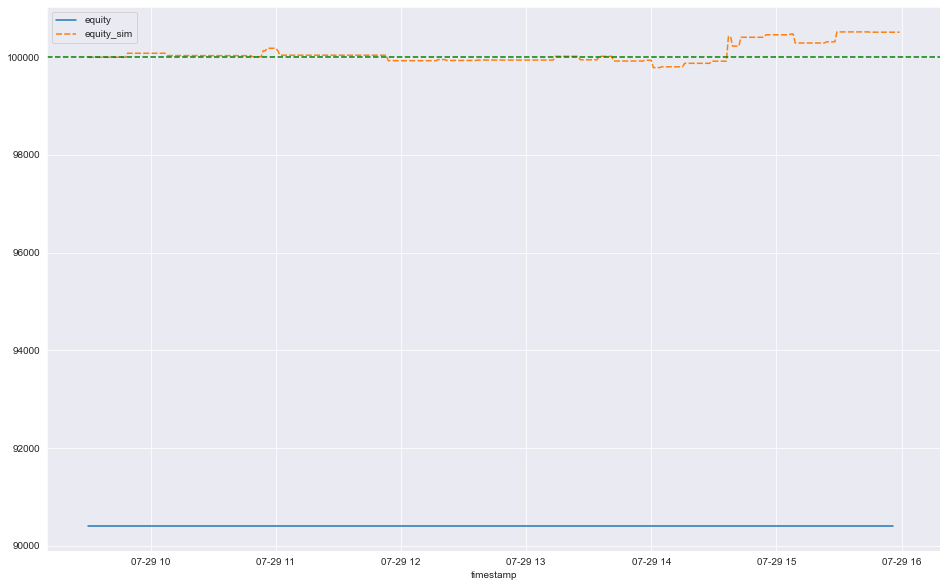

In [45]:
sns.set_style('darkgrid')
plt.subplots(figsize=(16,10))
graph = sns.lineplot(data=integrated_result)
graph.axhline(100000, ls='--', c='green')

plt.show()
